# Import libary

In [1]:
import pandas as pd
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
def get_feature(data):
    '''function to get all features and collect and categorical and numeric in dataframe
    pararmeter : data : dataframe'''
    categorical_features = [] #categorical feature list 
    numeric_features = [] # nubmerical feature list 
    features = data.columns.values.tolist() # collect all columns 
    for col in features: # foor loop features 
        if data[col].dtype != 'object':  # if type not equal to object
            numeric_features.append(col) # add to numberic 
        else: # if not 
            categorical_features.append(col)  # add to categorical
    return categorical_features,numeric_features # return the collected features


def fillna_data(data,numeric_features,categorical_features): 
    '''function fill missing value with mean and mode
    parameter data: dataframe
              numeric_features : number features
              categorical_features : group features'''
    for col in numeric_features: # for loop number features
        mean = data[col].mean() # find mean of number features
        data[col] = data[col].fillna(mean) # fill missing value with mean
    
    for col in categorical_features: # for loop group features
        mode = data[col].mode()[0] # find mode of group features 
        data[col] = data[col].fillna(mode) # fill missing values with mean 
        
        
def encode_categorical(data,categorical_features):
    '''function to change the categorical features to number
        parameter data : the dataframe
                  categorical_features : features that indicate groups'''
    for col in categorical_features: # for loop in the categorical features 
        le = LabelEncoder() # call label encoder 
        le.fit(list(data[col].astype(str).values)) # fit the lable encoder to dataframe 
        data[col] = le.transform(list(data[col].astype(str).values)) # transform dataframe with label encoder 
        
def performance_report(data_test,test_set,model):
    '''function to create the performance report
    parameter data_test: the test data X
              test_set : the test target 
              model    : the model that wanted to test'''
    
    prediction= model.predict(data_test) # create prediction
    cm=confusion_matrix(test_set,prediction) # create the confusion matrix
    
    # plot the confusion matrix
    conf_matrix=pd.DataFrame(data=cm,
                             columns=['Predicted:0','Predicted:1'],
                             index=['Actual:0','Actual:1'])
    plt.figure(figsize = (8,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu") # plot the heatmap

    print(metrics.accuracy_score(test_set, prediction)) # print accuracy
    print(metrics.classification_report(test_set, prediction)) # print classification report
    
    
def train_model(train_data,target,name):
    '''fucntion to train model with logistic regression by
    using the grid search for best parameter and return the best model
    and also save the model
    parameter  train_data : data for training 
               target     : target
               name : name of the model to be saved'''
    
    # logistic regression parameter
    param = { 'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l2'],
              'tol' : [0.1,0.01,0.001]}
    
    # find best parameter by creating grid search
    logis_gridcv = GridSearchCV(estimator=LogisticRegression(), 
                                param_grid=param,   
                                scoring='neg_log_loss',
                                cv=5)
    
    #start training and save the best parameter
    logis_gridcv.fit(train_data, target)
    
    # use best parameter as the setup
    logis = LogisticRegression(C = logis_gridcv.best_params_['C'],
                               penalty = logis_gridcv.best_params_['penalty'],
                               tol = logis_gridcv.best_params_['tol'])
    
    model = logis.fit(train_data,target) # return the trained model with best parameter
    
    # save the model to disk
    pickle.dump(model, open(name, 'wb'))
    return model

0.8410903341124708
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     22726
           1       0.72      0.45      0.55      6366

    accuracy                           0.84     29092
   macro avg       0.79      0.70      0.73     29092
weighted avg       0.83      0.84      0.83     29092



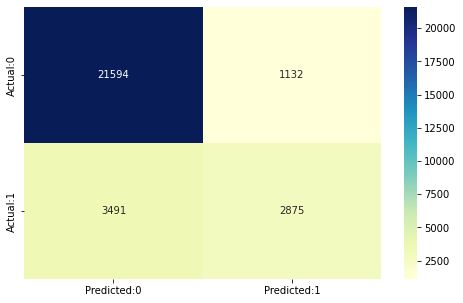

In [3]:
#### PREPARE DATA ####
def prepare(dataframe_location):
    
    df = pd.read_csv(dataframe_location) # import dataset
    df = df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm','Date'], axis=1) # drop columns 
    categorical_features,numeric_features  = get_feature(df) # get group and number feature
    fillna_data(df,numeric_features,categorical_features) # fill missing value
    encode_categorical(df,categorical_features) # encode group features
    y = df['RainTomorrow'] # setup target 
    X = df.drop('RainTomorrow', axis=1) # setup X
    X_scaled = StandardScaler().fit_transform(X) # normalize X
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0) # train test split
    return X_train, X_test, y_train, y_test 

#### MODEL BUILDING ####
X_train, X_test, y_train, y_test = prepare('weatherAUS/weatherAUS.csv')
model = train_model(X_train,y_train,'weather_model.sav')
performance_report(X_test,y_test,model)


In [5]:
# load save model 
loaded_model = pickle.load(open('weather_model.sav', 'rb'))
result = loaded_model.score(X_test, y_test)